# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.4f}'.format

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data_size = data.shape[0]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.0000",108.0000,2019-03-07T00:00:00,3,2.7000,16.0000,51.0000,8,NaN,...,25.0000,NaN,Санкт-Петербург,"18,863.0000","16,028.0000",1.0000,482.0000,2.0000,755.0000,NaN
1,7,"3,350,000.0000",40.4000,2018-12-04T00:00:00,1,NaN,11.0000,18.6000,1,NaN,...,11.0000,2.0000,посёлок Шушары,"12,817.0000","18,603.0000",0.0000,NaN,0.0000,NaN,81.0000
2,10,"5,196,000.0000",56.0000,2015-08-20T00:00:00,2,NaN,5.0000,34.3000,4,NaN,...,8.3000,0.0000,Санкт-Петербург,"21,741.0000","13,933.0000",1.0000,90.0000,2.0000,574.0000,558.0000
3,0,"64,900,000.0000",159.0000,2015-07-24T00:00:00,3,NaN,14.0000,NaN,9,NaN,...,NaN,0.0000,Санкт-Петербург,"28,098.0000","6,800.0000",2.0000,84.0000,3.0000,234.0000,424.0000
4,2,"10,000,000.0000",100.0000,2018-06-19T00:00:00,2,3.0300,14.0000,32.0000,13,NaN,...,41.0000,NaN,Санкт-Петербург,"31,856.0000","8,098.0000",2.0000,112.0000,1.0000,48.0000,121.0000


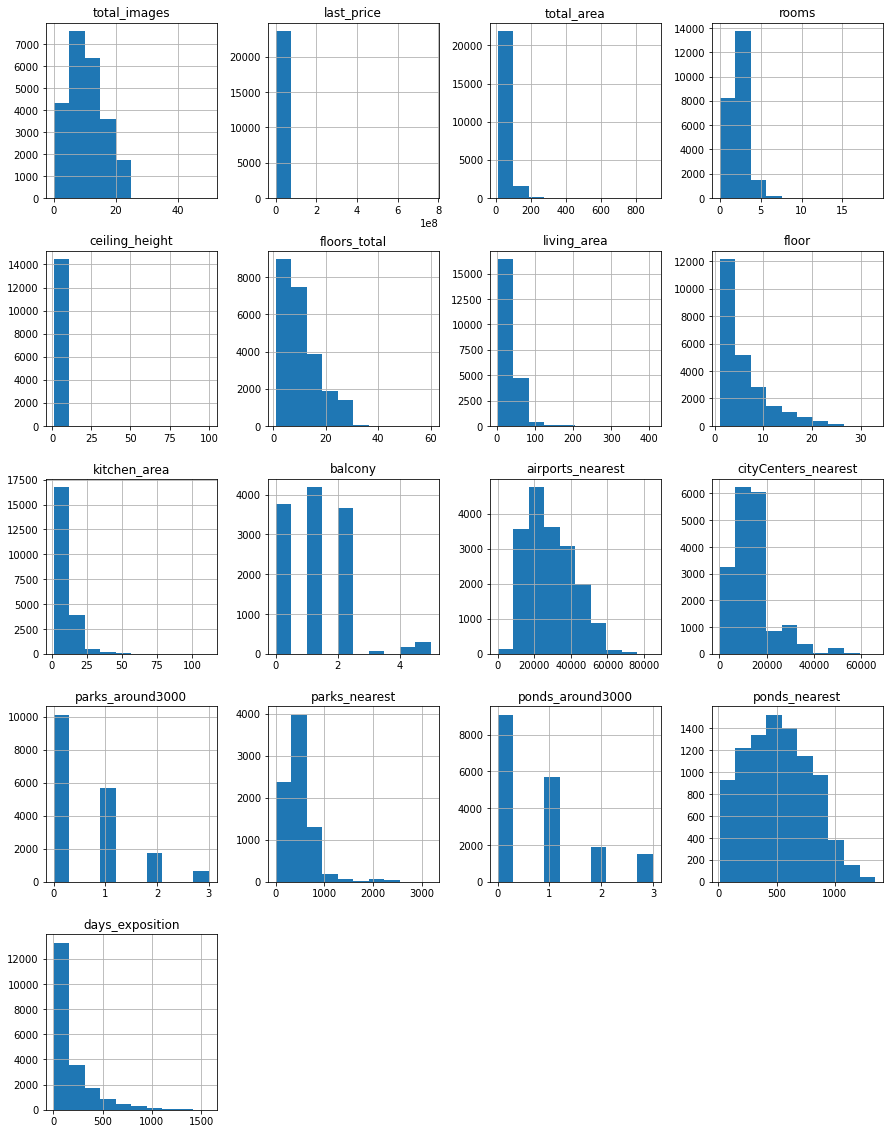

In [5]:
data.hist(figsize=(15,20))
plt.show()

In [6]:
data.rename(columns={'cityCenters_nearest': 'citycenters_nearest'}, inplace=True)
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'citycenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

**Вывод** <br>
В датасете 23699 наблюдений и 22 признака. <br>
По некоторым признакам присутствуют выбросы <br>
Исходя из гистограмм, на многих признаках распределение имеет правый "хвост", что вписывается в здравый смысл: например, для признака total_floors это просто означает, что малоэтажного жилья просто больше, чем высокоэтажного.

### Предобработка данных

In [7]:
(data.isna().sum() / data_size).sort_values(ascending=False)

is_apartment           0.8829
parks_nearest          0.6591
ponds_nearest          0.6156
balcony                0.4861
ceiling_height         0.3880
airports_nearest       0.2338
citycenters_nearest    0.2329
ponds_around3000       0.2328
parks_around3000       0.2328
days_exposition        0.1342
kitchen_area           0.0961
living_area            0.0803
floors_total           0.0036
locality_name          0.0021
total_images           0.0000
last_price             0.0000
studio                 0.0000
floor                  0.0000
rooms                  0.0000
first_day_exposition   0.0000
total_area             0.0000
open_plan              0.0000
dtype: float64

Мы нашли и посчитали пропуски, далее начнем разбираться с ними по отсортированному списку.

<b>is_apartment</b>

In [8]:
data['is_apartment'].dtype

dtype('O')

In [9]:
data.fillna('None').pivot_table(index='is_apartment', values='last_price', aggfunc=['median', 'count', 'std'])

,median,count,std
,last_price,last_price,last_price
is_apartment,,,
False,"4,700,000.0000",2725,"10,526,740.2538"
True,"6,900,000.0000",50,"16,169,673.4481"
None,"4,600,000.0000",20924,"10,913,775.3636"


In [10]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()

0

Медианная цена групп False и Nan и отклонение приблизительно соизмеримы. При этом для группы True значения сильно отличаются. Исходя из этих данных, а так же понимания, что апартаменты это достаточно редкая вещь на рынке недвижимости, заполняем пропуски значение False

<b>parks_nearest</b> и <b>parks_around3000</b>

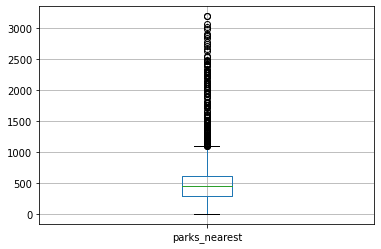

count   8,079.0000
mean      490.8046
std       342.3180
min         1.0000
25%       288.0000
50%       455.0000
75%       612.0000
max     3,190.0000
Name: parks_nearest, dtype: float64

In [11]:
data.boxplot('parks_nearest')
plt.show()
data['parks_nearest'].describe()

In [12]:
data['parks_around3000'].value_counts()

0.0000    10106
1.0000     5681
2.0000     1747
3.0000      647
Name: parks_around3000, dtype: int64

Для признака <b>parks_nearest</b> пропущено 66% данных. Данные находятся в диапазоне, который вполне соотносится с реальным миром - 3190 метров до ближайшего парка вполне реальное значение, так же как и 1 метр.<br>
Признак <b>parks_around3000</b> по похож по смыслу, он описывает схожую характеристику, но имеет меньше пропусков. Доминирующая группа в нем - 0 парков в 3000 метрах, заполним пропуск по ней

In [13]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_around3000'].isna().sum()

0

Проверим количество наблюдений, у которых признак <b>parks_nearest</b> пуст, при этом <b>parks_around3000</b> = 0. 

In [14]:
conditions = (data['parks_nearest'].isna()) & (data['parks_around3000']==0) # условие, озвученное выше
data[conditions].shape[0]

15620

In [15]:
data['parks_nearest'].isna().sum()

15620

In [16]:
(conditions == data['parks_nearest'].isna()).sum()

23699

После манипуляций с <b>parks_around3000</b> мы получили, что 100% пропусков в столбце <b>parks_nearest</b> совпадает со значением <b>parks_around3000</b> = 0. Из этого мы можем сделать вывод, что пропуски можно заполнить максимальной дистанцией до парку плюс несколько метров

In [17]:
data.loc[conditions, 'parks_nearest'] = 3050
data['parks_nearest'].isna().sum()

0

In [18]:
data[['parks_nearest', 'parks_around3000']] = data[['parks_nearest', 'parks_around3000']].astype('int32')

<b>ponds_nearest</b> и <b>ponds_around3000</b> <br>
Повторим такую же логику для прудов

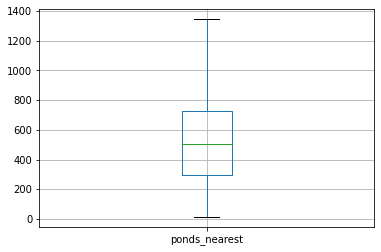

count   9,110.0000
mean      517.9809
std       277.7206
min        13.0000
25%       294.0000
50%       502.0000
75%       729.0000
max     1,344.0000
Name: ponds_nearest, dtype: float64

In [19]:
data.boxplot('ponds_nearest')
plt.show()
data['ponds_nearest'].describe()

In [20]:
data['ponds_around3000'].value_counts()

0.0000    9071
1.0000    5717
2.0000    1892
3.0000    1501
Name: ponds_around3000, dtype: int64

In [21]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_around3000'].isna().sum()

0

In [22]:
conditions = (data['ponds_nearest'].isna()) & (data['ponds_around3000']==0) # условие, озвученное выше
data[conditions].shape[0]

14589

In [23]:
data['ponds_nearest'].isna().sum()

14589

In [24]:
(conditions == data['ponds_nearest'].isna()).sum()

23699

In [25]:
data.loc[conditions, 'ponds_nearest'] = 3050
data['ponds_nearest'].isna().sum()

0

In [26]:
data[['ponds_nearest', 'ponds_around3000']] = data[['ponds_nearest', 'ponds_around3000']].astype('int32')

<b>balcony</b>

In [27]:
data['balcony'].value_counts()

1.0000    4195
0.0000    3758
2.0000    3659
5.0000     304
4.0000     183
3.0000      81
Name: balcony, dtype: int64

In [28]:
data.fillna('None').pivot_table(index='balcony', values='last_price', aggfunc=['median', 'count'])

,median,count
,last_price,last_price
balcony,,
0.0,"4,400,000.0000",3758
1.0,"4,395,000.0000",4195
2.0,"4,700,000.0000",3659
3.0,"6,500,000.0000",81
4.0,"6,999,000.0000",183
5.0,"6,800,000.0000",304
None,"4,700,000.0000",11519


In [29]:
data['balcony'] = data['balcony'].fillna(0)

До данному признаку у нас 49% пропусков. Скорее всего, данные не заполнялись, если балкон отсутствует. В противном случае восстановить истинное значение признака проблематично

<b>ceiling_height</b>

In [30]:
data['ceiling_height'].describe()

count   14,504.0000
mean         2.7715
std          1.2611
min          1.0000
25%          2.5200
50%          2.6500
75%          2.8000
max        100.0000
Name: ceiling_height, dtype: float64

Мы видим не только пропуски до данному признаку, но и выбросы. Поэтому сначала избавимся от ошибок в данных, а потом уже заполним пропуски

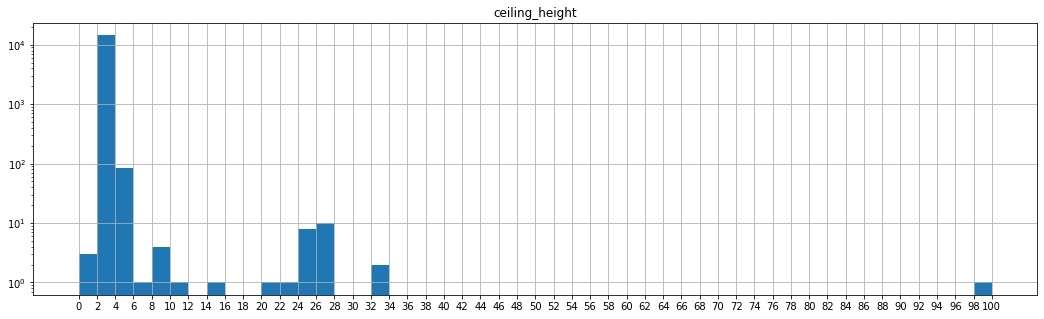

In [31]:
# используем логарифмичесий масштаб, чтобы оценить выбросы
data.hist('ceiling_height', range=(0, 100), bins=50, log=True, figsize=(18, 5))
plt.xticks(range(0, 102, 2))
plt.show()

In [32]:
print('Ниже 2.5: ', (data['ceiling_height']<2.5).sum())
print('От 2.5 до 3: ', ((data['ceiling_height']<3) & (data['ceiling_height']>=2.5)).sum())
print('От 3 до 4: ', ((data['ceiling_height']<4) & (data['ceiling_height']>=3)).sum())
print('От 4 до 5: ', ((data['ceiling_height']<5) & (data['ceiling_height']>=4)).sum())
print('От 5 до 6: ', ((data['ceiling_height']<6) & (data['ceiling_height']>=5)).sum())
print('От 6 до 25: ', ((data['ceiling_height']<25) & (data['ceiling_height']>=6)).sum())
print('От 25 до 35: ', ((data['ceiling_height']<35) & (data['ceiling_height']>=25)).sum())
print('От 35: ', (data['ceiling_height']>=35).sum())

Ниже 2.5:  73
От 2.5 до 3:  11790
От 3 до 4:  2527
От 4 до 5:  77
От 5 до 6:  7
От 6 до 25:  10
От 25 до 35:  19
От 35:  1


In [33]:
#разница в средней цене присутствует
print(data[(data['ceiling_height']<25) & (data['ceiling_height']>=5)]['last_price'].mean())
print(data[(data['ceiling_height']<5) & (data['ceiling_height']>=4)]['last_price'].mean())


29201235.29411765
23693168.83116883


В выводе выше мы приблизительно поделили значения признака на диапазоны, с которыми будем работать по индивидуальному сценарию:<br>
Потолкам ниже 2.5 метров выставим значение 2.5, поскольку это минимальное значение для потолков в жилых помещениях. <br>
Потолки от 2.5 до 5 метров оставим как. Погуглив, можно убедиться, что в элитном жилье бывают такие потолки. <br>
Наблюдения со значением от 5 до 25 мы будем считать частью элитного жилья и выставим чуть выше 5, поскольку существует разница в средней цене данной группы, и группы между 4 и 5 метрами. <br>
Диапазон между 25 и 35 будем считать ошибкой (по совету в инструкции к заданию), и разделим значение на 10
Наблюдение с потолков выше 35 удалим


In [34]:
def fix_ceiling_height(height):
    '''
    Функция получает высоту потолка и, при необходимости, возвращает исправленный вариант по условию
    '''
    if height < 2.5:
        height = 2.5
    elif height > 5 and height <= 25:
        height = 5.5
    elif height > 25 and height <= 35:
        height /= 10
    return height

In [35]:
data = data.drop(data[data['ceiling_height']>35].index).reset_index(drop=True)
data['ceiling_height'] = data['ceiling_height'].apply(fix_ceiling_height)
data['ceiling_height'].describe()

count   14,503.0000
mean         2.7306
std          0.2922
min          2.5000
25%          2.5200
50%          2.6500
75%          2.8000
max          5.5000
Name: ceiling_height, dtype: float64

In [36]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].mean())

По данному признаку мы заполнили пустые значения средним по выборке. Квартира со слишком высоким потолком удалена из выборки

<b>airports_nearest</b>

count   18,156.0000
mean    28,793.3324
std     12,631.1455
min          0.0000
25%     18,584.2500
50%     26,726.0000
75%     37,273.5000
max     84,869.0000
Name: airports_nearest, dtype: float64

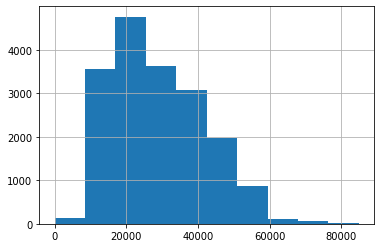

In [37]:
data['airports_nearest'].hist()
data['airports_nearest'].describe()

In [38]:
data[data['airports_nearest']<6000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21085,0,"7,000,000.0000",34.7000,2018-09-23T00:00:00,1,2.7000,9.0000,19.8000,3,False,...,6.0000,2.0000,Санкт-Петербург,0.0000,"22,801.0000",0,3050,0,3050,60.0000


In [39]:
data.loc[data['airports_nearest']<6000, 'airports_nearest'] = np.nan

Значения достаточно правдоподобны, если сверить на карте расстояние от городов/поселков до Пулково. Беспокоят только пропуски и значение 0. Для заполнения пропусков кажется логичным сгруппировать расстояния по городу, вычислить для каждого среднее и заполнить пропуск в соответсвии с полученными значениями по группам. <br>
Перед группировкой избавимся от неявных дубликатов

In [40]:
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

In [41]:
# без приведения к типу строки невозможно было осортировать список
data['locality_name'] = data['locality_name'].astype('str')
#sorted(data['locality_name'].unique()) #вывод закомментирован перед проверкой, слишком длинный список

Основные возможные причины неявных дубликатов мы устранили. Потенциальные задвоениями между деревней, селом и поселком городского типа не исключены, но требуют ручной проверки. <br>
Проверим, сколько пропуском мы сможем заполнить осознанно

In [42]:
# считаем среднее расстояние по городам, выдим количество наблюдений, где пропуск будет заполнен по среднему.
airport_by_locality = data.groupby('locality_name')['airports_nearest'].transform('median')
data['airports_nearest'].isna().sum() - airport_by_locality.isna().sum()

679

In [43]:
data['airports_nearest'] = data['airports_nearest'].fillna(airport_by_locality)

~Оставшиеся пропуски по расстоянию аэропортов встречаются в домах, которые находятся в деревнях и поселках, т.е. скорее всего это отдаленные пункты, поэтому данные по ним не заполняли. В рамках проекта заполним пропуски "в лоб", поставив значение чуть больше максимального.~ <br>
Выборочная проверка оставшихся населенных пунктов показала, что там есть как дома за 100км от аэропорта, так и в районе 15-25. Заполнять будем средним до датафрейму, за исключением наблюдений из Санкт-Петербурга

In [44]:
data['airports_nearest'] = data['airports_nearest']\
            .fillna(data[~(data['locality_name']=='санкт-петербург')]['airports_nearest'].mean())

In [45]:
data['airports_nearest'] = data['airports_nearest'].astype('int32')

Расстояние измеряется в метрах, хвосты из сантиметров можно смело убрать

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Снова хочу отметить, что пропуски ты прорабатываешь достаточно точечно. 
</div 

<b>citycenters_nearest</b>

Здесь ситуация, аналогичная расстоянию до аэропортов. Более того, пропуск в столбце <b>citycenters_nearest</b> почти всегда совпадает с пропуском в столбце <b>airports_nearest</b>. Поэтому действовать будем аналогично.

In [46]:
data['citycenters_nearest'].describe()

count   18,179.0000
mean    14,191.6028
std      8,608.5114
min        181.0000
25%      9,238.0000
50%     13,099.0000
75%     16,293.0000
max     65,968.0000
Name: citycenters_nearest, dtype: float64

In [47]:
citycenters_by_locality = data.groupby('locality_name')['citycenters_nearest'].transform('median')
data['citycenters_nearest'].isna().sum() - citycenters_by_locality.isna().sum()

655

In [48]:
data['citycenters_nearest'] = data['citycenters_nearest'].fillna(citycenters_by_locality)
data['citycenters_nearest'] = data['citycenters_nearest']\
            .fillna(data[~(data['locality_name']=='санкт-петербург')]['citycenters_nearest'].mean())

In [49]:
data['citycenters_nearest']= data['citycenters_nearest'].astype('int32')

<b>days_exposition</b>

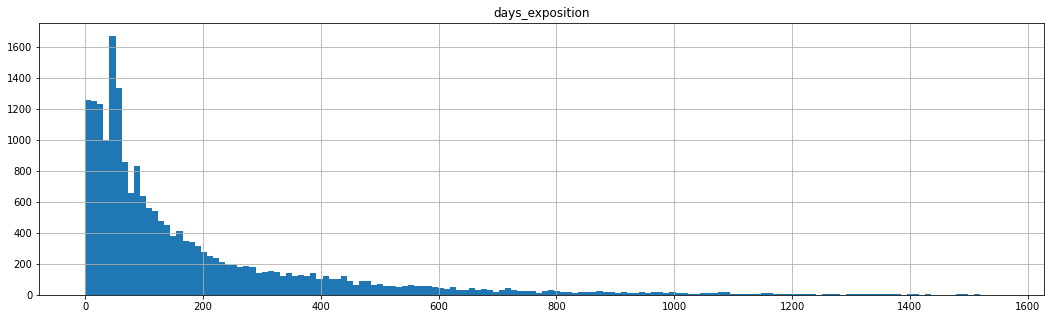

In [50]:
data.hist('days_exposition', range=(0, 1550), bins=150, figsize=(18, 5))
plt.show()

In [51]:
data[data['days_exposition']>365*2]['last_price'].mean()

8868128.817576565

In [52]:
data[data['days_exposition']<=365*2]['last_price'].mean()

6166870.535110796

Скорее всего большие значения это не оишбка в данных, а реальная ситуация дел, обусловленная сложностью конкретной сделки<br>
Пропуск не может считаться признаком того, что сделка не закрыта, поскольку в признаке <b>last_price</b> нет пропусков. Заполним медианой

In [53]:
#data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())

<b>living_area</b>

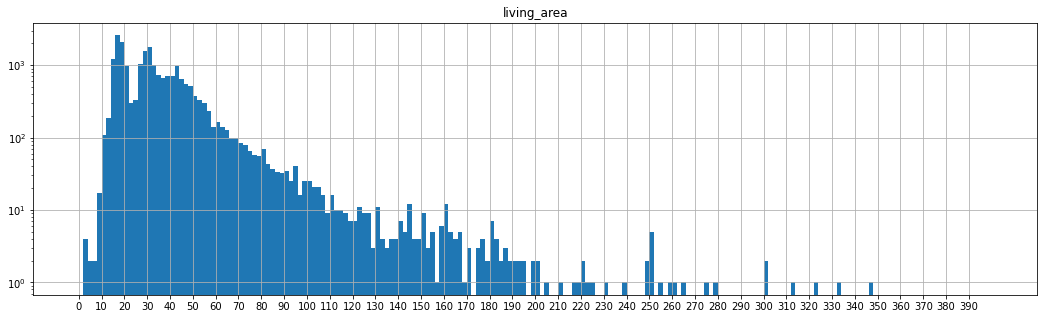

In [54]:
data.hist('living_area', range=(0, 400), bins=200, log=True, figsize=(18, 5))
plt.xticks(range(0,400,10))
plt.show()

In [55]:
data[data['living_area']>200]['rooms'].describe()

count   31.0000
mean     7.5161
std      3.3354
min      4.0000
25%      5.5000
50%      7.0000
75%      7.5000
max     19.0000
Name: rooms, dtype: float64

In [56]:
data[data['living_area']<20]['total_area'].describe()

count   6,231.0000
mean       36.0749
std         6.3393
min        12.0000
25%        32.0000
50%        35.4000
75%        40.0000
max       139.0000
Name: total_area, dtype: float64

Слишком большые значения не кажутся ошибками в данных, поскольку количество комнат соответствует жилой площади площади. Однако в задании требуется избавиться от слишком больших значений.

In [57]:
data.drop(data[data['living_area']>220].index, inplace=True)

С аномально маленькими значения чуть сложнее. Total_area имеет нормальные (с точки зрения здравого смысла) значения там, где living_area кажется нереалистичным. Возможно, я ошибочно интерпретирую этот признак как площадь комнаты и требуется уточнение, что действительно имеется здесь ввиду.

In [58]:
data['living_area'] = data['living_area'].fillna(data['living_area'].median())

<b>kitchen_area</b>

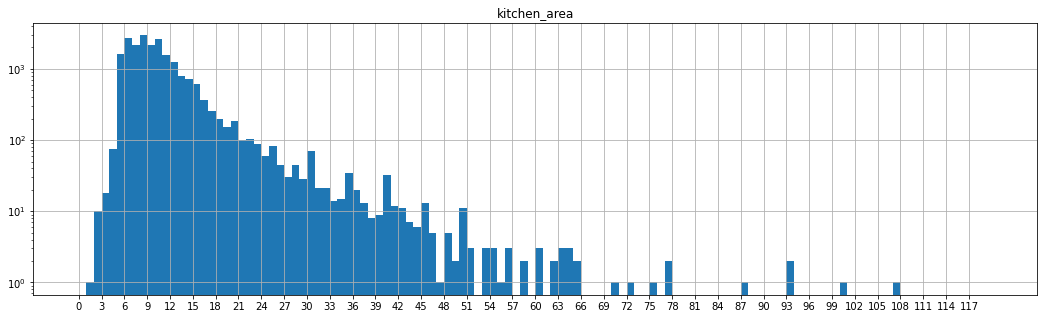

In [59]:
data.hist('kitchen_area', range=(0, 120), bins=120, log=True, figsize=(18, 5))
plt.xticks(range(0,120,3))
plt.show()

In [60]:
data[(data['kitchen_area']>60)]['total_area'].describe()

count    20.0000
mean    192.7550
std      61.2482
min     118.0000
25%     149.0000
50%     175.9500
75%     234.9250
max     310.0000
Name: total_area, dtype: float64

Большие объемы кухни вполне себе укладываются в ту же логику, что и большая жилая площать - это не ошибки в данных



In [61]:
kitchen_to_total_ratio = data['kitchen_area'].mean() / data['total_area'].mean()

In [62]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] * kitchen_to_total_ratio)

In [63]:
data.drop(data[data['kitchen_area'] > 66].index, inplace=True)

Посчитаем среднее соотношение размера кухни к общей площади, с помощью него заполним пропуски. Таким же способ можно было бы заполнить и living_area. Наверное, так было бы правильнее, потому что мы заполняем пропуск, основываясь на достоверной информации по данному наблюдению, а не просто по среднему.

<b>floors_total</b>

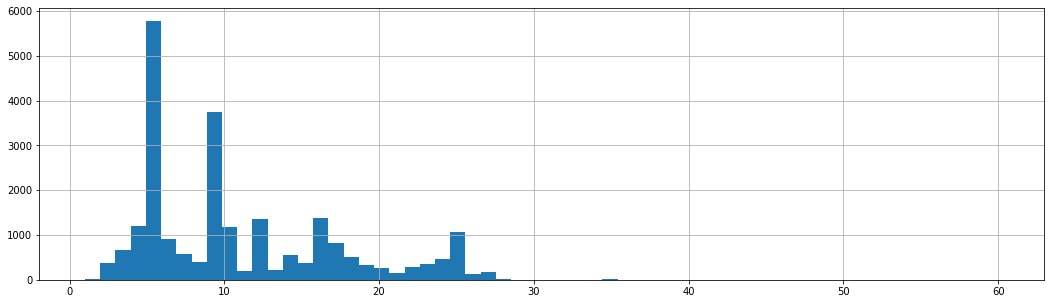

In [64]:
data['floors_total'].hist(bins=60, figsize=(18, 5))
plt.show()

Предлагаю следующий способ заполнения: <br>
если этаж квартиры <9 - считаем что дом 9 этажей. Если больше - то дом на один этаж выше, чем распологается квартира <br>
один этаж мы добавляем, потому что вероятность того, что квартиры на последнем этаже ниже, чем не на последнем.

In [65]:
def fill_floors_total(floor):
    if floor < 9:
        return 9
    else:
        return floor + 1

In [66]:
data['floors_total'] = data['floors_total'].fillna(data['floor'].apply(fill_floors_total))

In [67]:
data['floors_total'] = data['floors_total'].astype('int32')

<b>floor</b>

<AxesSubplot:>

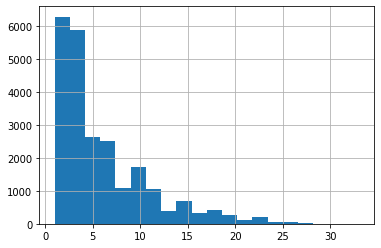

In [68]:
data['floor'].hist(bins=20)

выбросов нет, тип данных верных

<b>open_plan</b>

In [69]:
data['open_plan'].value_counts()

False    23590
True        67
Name: open_plan, dtype: int64

In [70]:
data['open_plan'].dtypes

dtype('bool')

вмешательство не требуется

<b>rooms</b>

<AxesSubplot:>

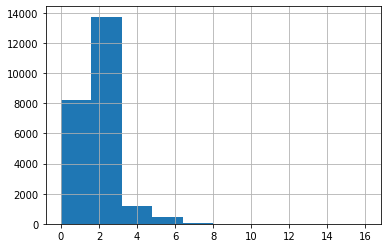

In [71]:
data['rooms'].hist()

In [72]:
data['rooms'].dtypes

dtype('int64')

<b>studio</b>

In [73]:
data['studio'].value_counts()

False    23508
True       149
Name: studio, dtype: int64

In [74]:
data['studio'].dtypes

dtype('bool')

<b>total_images</b>

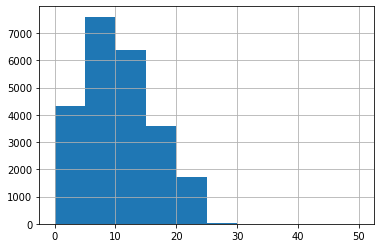

In [75]:
data['total_images'].hist()

plt.show()

In [76]:
data['total_images'].dtypes

dtype('int64')

<b>total_area</b>

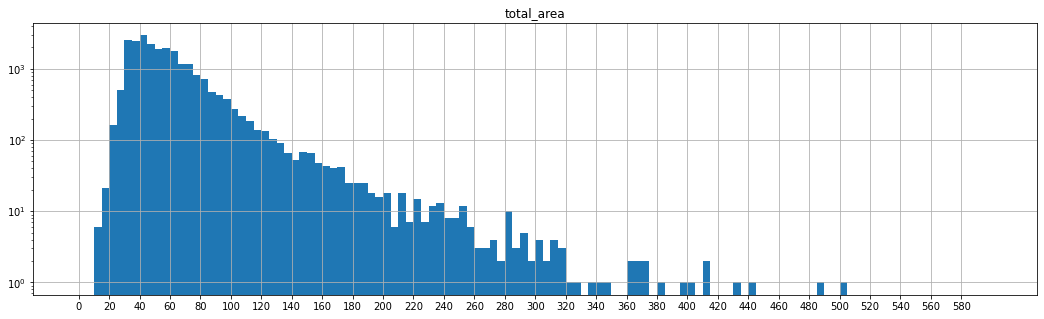

In [77]:
data.hist('total_area', range=(0, 600), bins=120, log=True, figsize=(18, 5))
plt.xticks(range(0,600,20))
plt.show()

In [78]:
data[data['total_area']>350].sample(frac=0.3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
14991,19,"45,000,000.0000",413.5000,2018-09-20T00:00:00,7,2.7306,20,74.2000,18,False,...,13.9000,0.0000,санкт-петербург,18748,4341,0,3050,0,3050,182.0000
21955,19,"130,000,000.0000",431.0000,2017-10-02T00:00:00,7,3.7000,8,220.0000,5,False,...,20.0000,5.0000,санкт-петербург,26757,12245,0,3050,0,3050,161.0000
6621,20,"99,000,000.0000",488.0000,2017-04-09T00:00:00,5,2.9500,20,216.0000,17,False,...,50.0000,0.0000,санкт-петербург,27641,4598,1,646,1,368,351.0000
3117,19,"140,000,000.0000",631.0000,2019-03-30T00:00:00,7,2.7306,5,30.0000,5,False,...,60.0000,0.0000,санкт-петербург,25707,4972,0,3050,2,210,NaN
10684,6,"32,894,076.0000",364.7000,2019-05-02T00:00:00,7,3.3200,3,30.0000,1,False,...,64.0793,5.0000,санкт-петербург,26757,12245,0,3050,0,3050,NaN


In [79]:
data.drop(data[data['total_area']>350].index, inplace=True)

Удалим выбросы. Повторюсь, сложно определить, была ли ошибка в данных, либо перед нам просто дорогое жилье.

<b>last_price</b>

In [80]:
data['last_price'].describe()

count        23,641.0000
mean      6,310,432.1109
std       7,826,497.6463
min          12,190.0000
25%       3,400,000.0000
50%       4,620,000.0000
75%       6,750,000.0000
max     330,000,000.0000
Name: last_price, dtype: float64

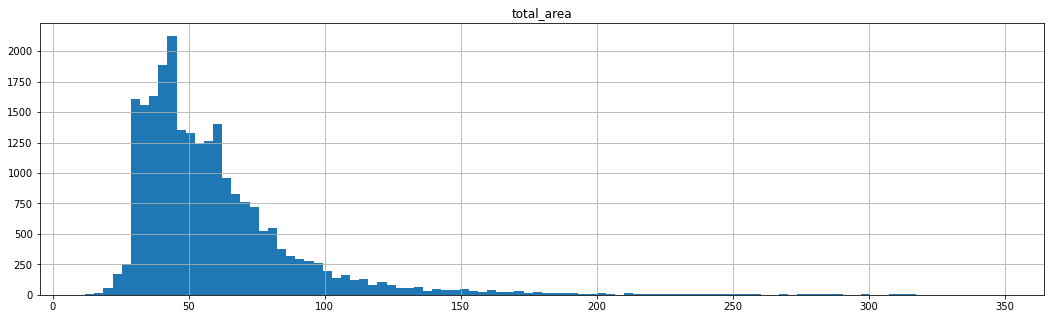

In [81]:
data.hist('total_area', bins=100, figsize=(18, 5))
plt.show()

In [82]:
data.drop(data[data['last_price'] > data['last_price'].quantile(0.98)].index, inplace=True)
data.drop(data[data['last_price']<200000].index, inplace=True)

Удалим слишком большие значения, удалив всё что больше 98 квантиля. Наблюдение с нереалистично маленькой стоимостью так же будет удалено

<b>first_day_exposition</b>

In [83]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

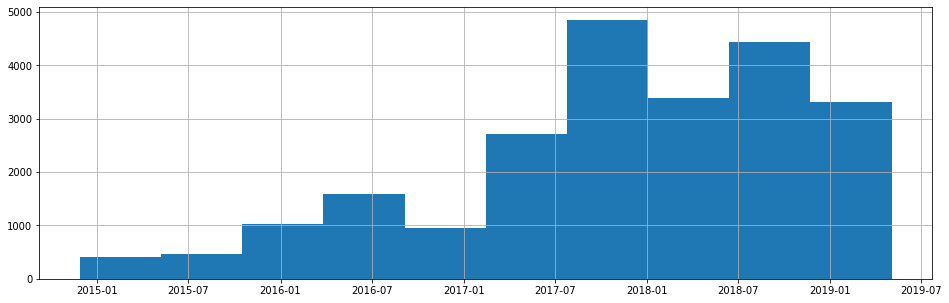

In [84]:
data['first_day_exposition'].hist(figsize=(16,5))
plt.show()

переводим в формат даты. Гистограмма ради интереса, похоже в 2017 году сервис стал набирать популярность

**Вывод по заданию 2** <br>


In [85]:
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23167 entries, 0 to 23166
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23167 non-null  int64         
 1   last_price            23167 non-null  float64       
 2   total_area            23167 non-null  float64       
 3   first_day_exposition  23167 non-null  datetime64[ns]
 4   rooms                 23167 non-null  int64         
 5   ceiling_height        23167 non-null  float64       
 6   floors_total          23167 non-null  int32         
 7   living_area           23167 non-null  float64       
 8   floor                 23167 non-null  int64         
 9   is_apartment          23167 non-null  bool          
 10  studio                23167 non-null  bool          
 11  open_plan             23167 non-null  bool          
 12  kitchen_area          23167 non-null  float64       
 13  balcony         

Представленный датасет содержал достаточно чистую информацию. Практически все выбросы, которые были удалены можно объяснить тем, что это реально дорогая недвижимость, которая выбивается из обычного рынка. <br>
Пропуски в данных удалось заполнить, удалять какие-либо столбцы не пришлось.<br>
В результате проделанных манипуляциий, размер датасета сократился менее чем на 5%

### Посчитайте и добавьте в таблицу новые столбцы

In [86]:
# цена одного квадратного метра;
data['square_meter_price'] = data['last_price'] / data['total_area']

<AxesSubplot:>

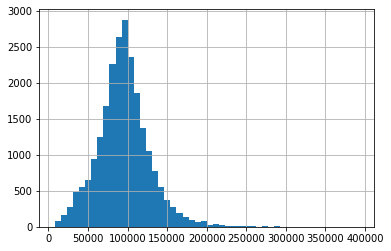

In [87]:
data['square_meter_price'].hist(bins=50)

Снова имеем хвост вправо за счет дорогих квартир

In [88]:
# день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
data['dayofweek_exposition'] = data['first_day_exposition'].dt.dayofweek

<AxesSubplot:>

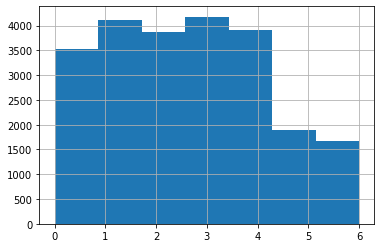

In [89]:
data['dayofweek_exposition'].hist(bins=7)

В выходные дни объявления выкладывают значительно реже, чем в будни

In [90]:
#месяц публикации объявления
data['month_exposition'] = data['first_day_exposition'].dt.month

<AxesSubplot:>

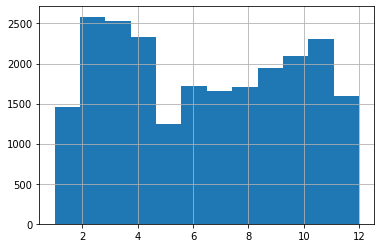

In [91]:
data['month_exposition'].hist(bins=12)

Февраль, март и апрель стабильно активны. Январь и май выпадает, в том числе за счет длинных выходных (коррелирует с выводом о днях недели). Летние "отпускные" месяцы активность ниже обычно, в осенние месяца активность начинает расти

In [92]:
#год публикации объявления
data['year_exposition'] = data['first_day_exposition'].dt.year

<AxesSubplot:>

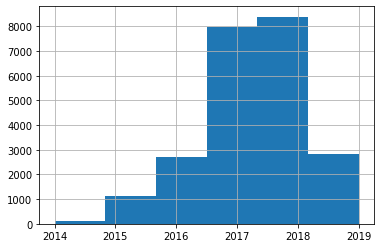

In [93]:
data['year_exposition'].hist(bins=6)

In [94]:
data['first_day_exposition'].max()

Timestamp('2019-05-03 00:00:00')

Резкий рост популярности сервиса с 2014 по 2017 год, небольшой рост в 2018. 2019 год еще не закрыт, поэтому рано делать выводы

In [95]:
#тип этажа квартиры (значения — «первый», «последний», «другой»)
def floor_type(row):
    if row['floor'] == row['floors_total']:
        return 'последний'
    elif row['floor'] == 1:
        return 'первый'
    else:
        return 'другой'

In [96]:
data['floor_type'] = data.apply(floor_type, axis=1)
data['floor_type'].value_counts()

другой       17055
последний     3246
первый        2866
Name: floor_type, dtype: int64

<AxesSubplot:>

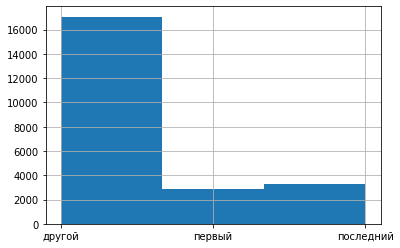

In [97]:
data['floor_type'].hist(bins=3)

все логично, первые и последнии этажи встречаются реже, чем остальные

In [98]:
# расстояние в км до центра города
data['citycenters_nearest_km'] = data['citycenters_nearest'] / 1000

<AxesSubplot:>

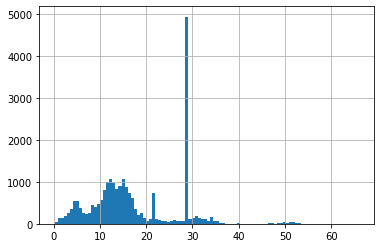

In [99]:
data['citycenters_nearest_km'].hist(bins=100)

Пик около 20 и 30км - следствие заполнения пропусков

### Исследовательский анализ данных

#### Первый шаг с изучением признаков, построением диаграм и выводами был сделан на этапе заполнения пропусков

#### Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.

<AxesSubplot:>

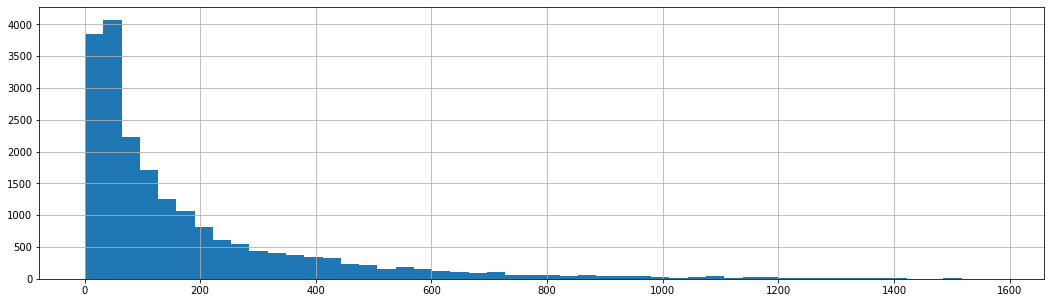

In [100]:
data['days_exposition'].hist(bins=50, figsize=(18,5))

In [101]:
print('Среднее:', data['days_exposition'].mean())
print('Медиана:', data['days_exposition'].median())

Среднее: 178.31984892157837
Медиана: 94.0


Обычно продажа занимает 95 дней (медиана). необычно долгими или быстрыми будем считать по интерквартильному размаху - более 195 или менее 45 дней

<AxesSubplot:>

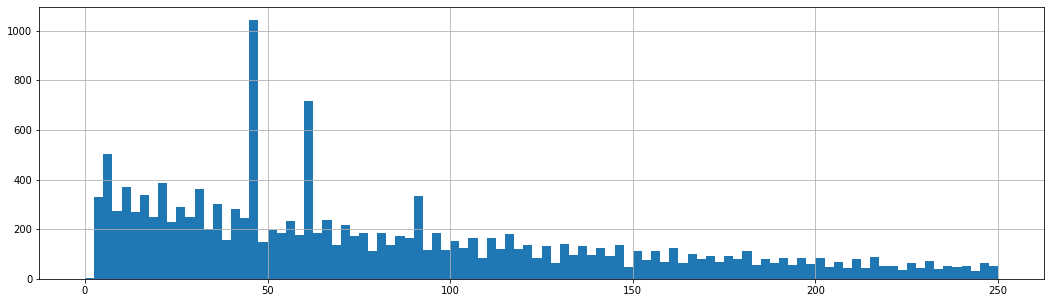

In [102]:
data['days_exposition'].hist(bins=100, figsize=(18,5), range=(0,250))

In [103]:
data['days_exposition'].value_counts()[:5]

45.0000    879
60.0000    538
7.0000     233
30.0000    205
90.0000    185
4.0000     175
3.0000     156
5.0000     146
Name: days_exposition, dtype: int64

In [104]:
columns = ['total_area', 'living_area', 'kitchen_area',\
           'rooms', 'dayofweek_exposition', 'month_exposition', 'year_exposition']

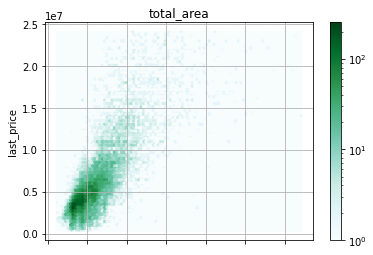

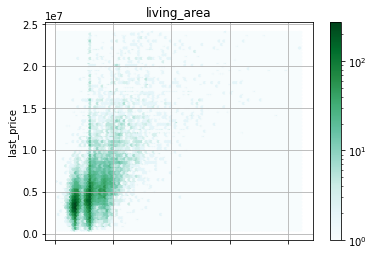

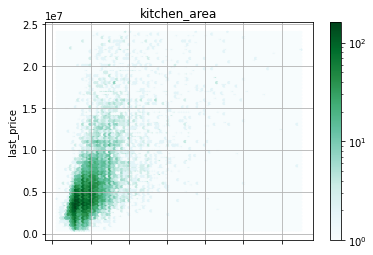

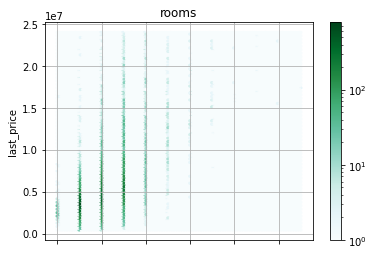

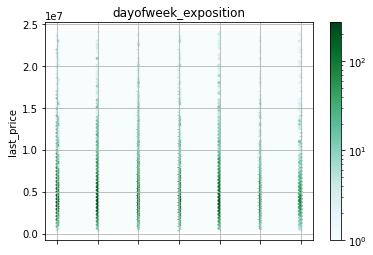

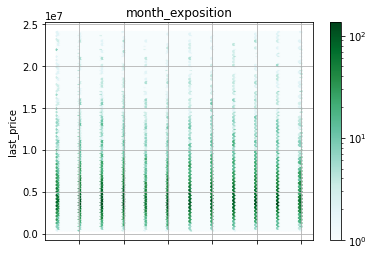

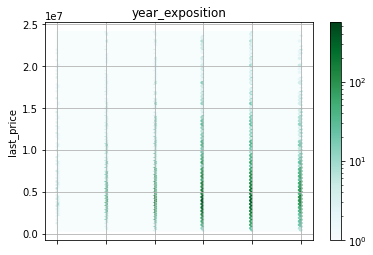

In [105]:
for column in columns:
    data.plot.hexbin(x=column, y='last_price', bins='log')
    plt.title(column)
    plt.grid()

Наблюдается линейная зависимость цены на квартиру от её фактических характеристик: площадь, жилая площадь, площадь кухни, кол-во комнат. Надо отменить, что данные признаки в какой-то мере коррелируют друг с другом, поскольку все они описывают площадь. <br>
Зависимости цена от того, в какой день или месяц было подано объявление, нет

[]

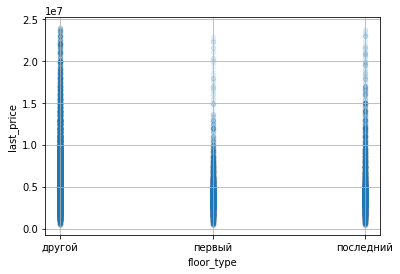

In [106]:
data.plot.scatter(x='floor_type', y='last_price', alpha=0.05)
plt.grid()
plt.plot()

На первом этаже самые недорогие квартиры, далее распологается последний этаж. Чаще всего дорогое жилье на других этажах

In [107]:
data['locality_name'].value_counts()[:10]

санкт-петербург      15202
поселок мурино         556
поселок шушары         440
всеволожск             397
пушкин                 360
колпино                337
поселок парголово      327
гатчина                307
деревня кудрово        299
выборг                 237
Name: locality_name, dtype: int64

In [108]:
data.groupby('locality_name')['square_meter_price'].\
            agg(['mean', 'count']).sort_values(['count', 'mean'], ascending=False)[:10].sort_values('mean')[['mean']]

,mean
locality_name,
выборг,"58,141.9092"
всеволожск,"67,214.2526"
гатчина,"68,746.1468"
колпино,"75,333.2958"
поселок шушары,"78,677.3642"
поселок мурино,"85,681.7626"
поселок парголово,"90,175.9135"
деревня кудрово,"92,473.5476"
пушкин,"101,788.5721"


По заданному условию, самый дешевый квадратный метр в Выборге, а самый дорогой в Санкт-Петербурге

In [114]:
data['citycenters_nearest_km'] = data['citycenters_nearest_km'].round()

<AxesSubplot:xlabel='citycenters_nearest_km'>

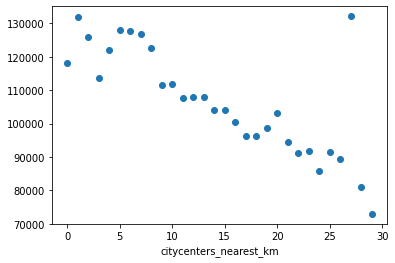

In [117]:
data[data['locality_name']=='санкт-петербург'].groupby('citycenters_nearest_km')['square_meter_price'].mean().plot(style='o')

Ближе к центру практически нет дешевых квартир, в то время как за 20км  от центр очень редко выстречается недвижимость стоимостью выше средней.  На графике видно обратную зависимость в диапазоне от 30 до ~20км.

### Общий вывод

Основная часть недвижимости имеет достаточно простые зависимости стоимости от физических факторов, таких как площадь или близость к центру.<br>
Близость к центру не всегда показательных фактор. Например, для Санкт-Петербурга мы увидели зависимость, тогда как для пригорода это не настолько значимый фактор <br>
Санкт-Петербург оказался относительно малоэтажным городом - 75% объявлений не выше 9-ого этажа